In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image

from pathlib import Path
from keras import regularizers
from keras.applications import ResNet50
from IPython.display import Markdown, display
from keras.layers import BatchNormalization
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

In [25]:
dir_ = Path('C:/Users/sbrrd/Desktop/dataset/Train/일반')
val_dir_ = Path('C:/Users/sbrrd/Desktop/dataset/Validation/일반')

import glob
types = ('**/*.jpg', '**/*.png','**/*.jpeg') # the tuple of file types
files_grabbed = []
test_files_grabbed = []
for files in types:
    files_grabbed.extend(dir_.glob(files))
    test_files_grabbed.extend(val_dir_.glob(files))

def proc_img(filepath):
    """
   		이미지데이터의 경로와 label데이터로 데이터프레임 만들기
    """

    labels = []
    for i in range(len(filepath)):
        if(str(filepath[i]).split("\\")[-2] == '무'):
            labels.append(str(filepath[i]).split("\\")[-2])
        else:
            labels.append(str(filepath[i]).split("\\")[-3])

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # 경로와 라벨 concatenate
    df = pd.concat([filepath, labels], axis=1)

    # index 재설정
    df = df.sample(frac=1,random_state=0).reset_index(drop = True)

    return df

df = proc_img(files_grabbed)
test_df = proc_img(test_files_grabbed)
df.head(5)

,Filepath,Label
0,C:\Users\sbrrd\Desktop\dataset\Train\일반\각막궤양\무...,무
1,C:\Users\sbrrd\Desktop\dataset\Train\일반\결막염\유\...,결막염
2,C:\Users\sbrrd\Desktop\dataset\Train\일반\각막궤양\무...,무
3,C:\Users\sbrrd\Desktop\dataset\Train\일반\각막부골편\...,각막부골편
4,C:\Users\sbrrd\Desktop\dataset\Train\일반\안검염\유\...,안검염


In [26]:
test_df.head(5)

,Filepath,Label
0,C:\Users\sbrrd\Desktop\dataset\Validation\일반\각...,무
1,C:\Users\sbrrd\Desktop\dataset\Validation\일반\비...,비궤양성각막염
2,C:\Users\sbrrd\Desktop\dataset\Validation\일반\결...,무
3,C:\Users\sbrrd\Desktop\dataset\Validation\일반\각...,무
4,C:\Users\sbrrd\Desktop\dataset\Validation\일반\각...,무


In [27]:
#데이터 라벨링된 결과
print(f'Number of pictures: {df.shape[0]}\n')
print(f'Number of different labels: {len(df.Label.unique())}\n')
print(f'Labels: {df.Label.unique()}\n')

#데이터 라벨링된 결과
print(f'Number of pictures: {test_df.shape[0]}\n')
print(f'Number of different labels: {len(test_df.Label.unique())}\n')
print(f'Labels: {test_df.Label.unique()}')

Number of pictures: 23019

Number of different labels: 6

Labels: ['무' '결막염' '각막부골편' '안검염' '각막궤양' '비궤양성각막염']

Number of pictures: 2918

Number of different labels: 6

Labels: ['무' '비궤양성각막염' '안검염' '결막염' '각막부골편' '각막궤양']


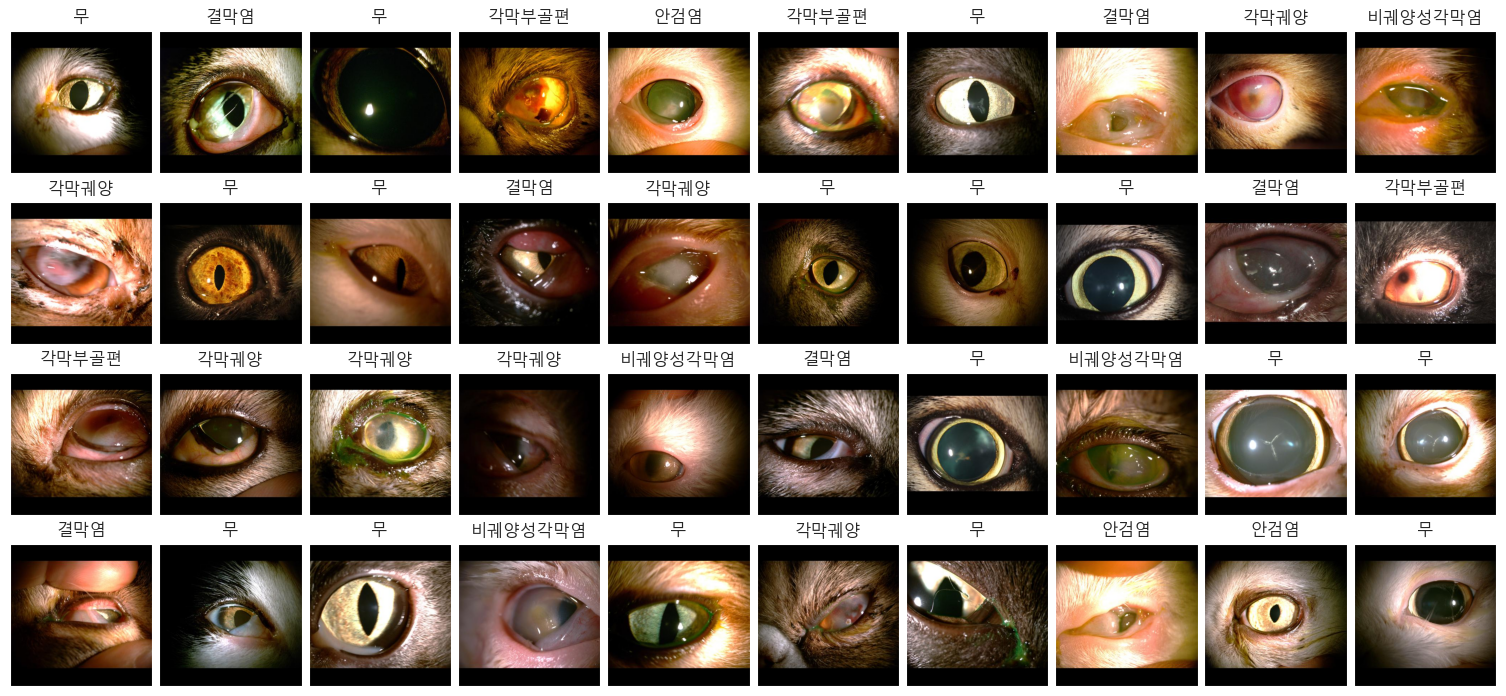

In [28]:
#사진들의 라벨링된 결과를 확인하기 위해 이미지 출력
plt.rc("font", family="Malgun Gothic")

fig, axes = plt.subplots(nrows=4, ncols=10, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(Image.open(df.Filepath[i]))
    ax.set_title(df.Label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

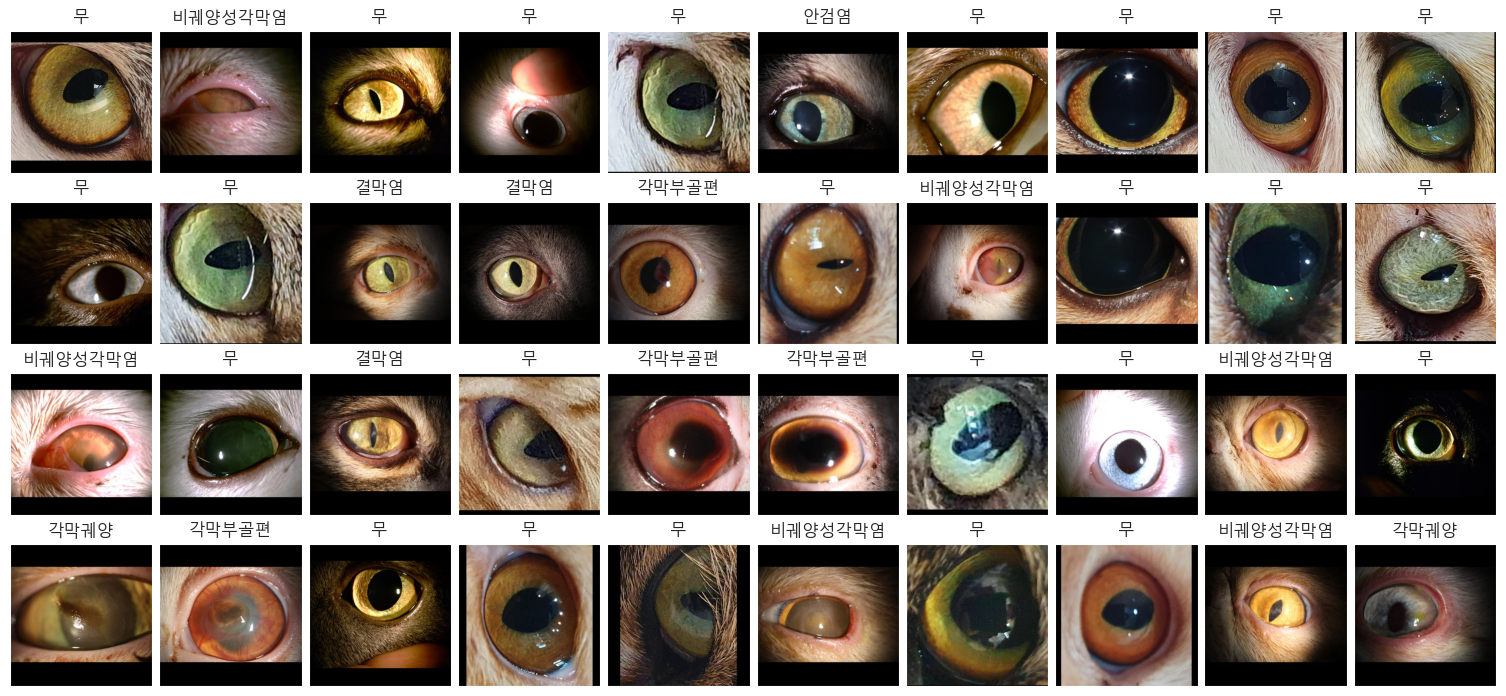

In [29]:
#사진들의 라벨링된 결과를 확인하기 위해 이미지 출력
plt.rc("font", family="Malgun Gothic")

fig, axes = plt.subplots(nrows=4, ncols=10, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(Image.open(test_df.Filepath[i]))
    ax.set_title(test_df.Label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

In [30]:
def create_gen():
    # 생성기 및 데이터 증강으로 이미지 로드
    train_generator = ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
        validation_split=0.2
    )

    test_generator = ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
    )

    train_images = train_generator.flow_from_dataframe(
        dataframe=df,
        x_col='Filepath', # 파일위치 열이름
        y_col='Label', # 클래스 열이름
        target_size=(224, 224), # 이미지 사이즈
        color_mode='rgb', # 이미지 채널수
        class_mode='categorical', # Y값(Label값)
        batch_size=32,
        shuffle=True, # 데이터를 섞을지 여부
        seed=0,
        subset='training', # train 인지 val인지 설정
        rotation_range=30, # 회전제한 각도 30도
        zoom_range=0.15, # 확대 축소 15%
        width_shift_range=0.2, # 좌우이동 20%
        height_shift_range=0.2, # 상하이동 20%
        shear_range=0.15, # 반시계방햐의 각도
        horizontal_flip=True, # 좌우 반전 True
        fill_mode="nearest"
        # 이미지 변경시 보완 방법 (constant, nearest, reflect, wrap) 4개 존재
    )

    val_images = train_generator.flow_from_dataframe(
        dataframe=df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='validation',
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    test_images = test_generator.flow_from_dataframe(
        dataframe=test_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=False
    )

    return train_generator,test_generator,train_images,val_images,test_images

In [31]:
def get_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(6, activation='softmax')
    ])
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [32]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                           patience=5),
             tf.keras.callbacks.ModelCheckpoint(filepath='best_model_v2.h5',
                                             monitor='val_loss',
                                             save_best_only=True)]


train_generator,test_generator,train_images,val_images,test_images=create_gen()

with tf.device('/GPU:0'):
    model = get_model() #가장 좋은 성과를 낸 모델을 사용
    history = model.fit(train_images,validation_data=val_images,epochs=10 ,callbacks=callbacks)

Found 18416 validated image filenames belonging to 6 classes.
Found 4603 validated image filenames belonging to 6 classes.
Found 2918 validated image filenames belonging to 6 classes.
Epoch 1/10
576/576 [==============================] - 520s 901ms/step - loss: 1.2679 - accuracy: 0.5422 - val_loss: 1.1355 - val_accuracy: 0.5900
Epoch 2/10
576/576 [==============================] - 472s 820ms/step - loss: 1.0889 - accuracy: 0.6125 - val_loss: 1.0578 - val_accuracy: 0.6172
Epoch 3/10
576/576 [==============================] - 481s 834ms/step - loss: 1.0069 - accuracy: 0.6369 - val_loss: 0.9416 - val_accuracy: 0.6598
Epoch 4/10
576/576 [==============================] - 481s 834ms/step - loss: 0.9290 - accuracy: 0.6655 - val_loss: 0.9457 - val_accuracy: 0.6596
Epoch 5/10
576/576 [==============================] - 473s 821ms/step - loss: 0.8634 - accuracy: 0.6863 - val_loss: 0.8778 - val_accuracy: 0.6837
Epoch 6/10
576/576 [==============================] - 457s 794ms/step - loss: 0.8060 -

In [36]:
model.save('cat_model_v2.h5')

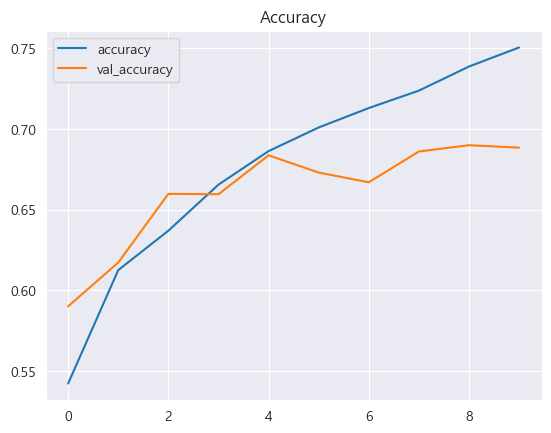

In [33]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

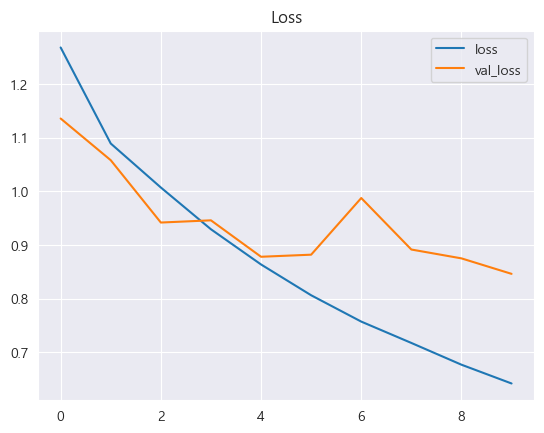

In [34]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()